# Lévy C-Curve — Project Demonstration (Classic, Variants, Analysis)

This notebook demonstrates the full workflow required by the project brief:

1. **Classic fractal implementation** — clean, documented Python with visualizations across iterations.
2. **Fractal modification** — explore variants (generalized angle; stochastic L-system), still fractal-like.
3. **Theory** — short background: construction, history, and mathematical significance.
4. **Analysis & conclusions** — compare classic vs modified, highlight preserved properties and visible differences.

> **How to run:** ensure the project is installed (e.g., `uv sync`, then `uv run jupyter lab`) and that the
> Python package is importable (project root on `PYTHONPATH`, or installed in the venv).


In [ ]:
# Imports & setup
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

from fractals.levy_c import LevyCCurve
from fractals.plotting import plot_polyline, plot_scatter, plot_iterations_grid, plot_ifs_progression
from fractals.metrics import estimate_box_dimension
from fractals.variants import levy_ifs_generalized

# A small helper for consistent styling
plt.rcParams.update({
    "figure.figsize": (6, 6),
    "axes.titlesize": 12,
})

## 1) Classic Lévy C-curve — Theory (short)

- **Construction (L-system):** start from axiom `F`, angle \(\alpha = 45^\circ\).  
  Apply the rule `F → +F--F+` for a chosen number of iterations. Turtle interpretation:
  - `F`: draw forward one step,
  - `+`: rotate right by \(\alpha\),
  - `-`: rotate left by \(\alpha\).
- **IFS form (chaos game):** two similitudes with scale \(s = 1/\sqrt{2}\) and rotations by \(\pm 45^\circ\),
  with translations placing the two parts to form the curve.
- **Similarity dimension:** for two equal-scale pieces, solve \(2 \cdot s^D = 1\). With \(s = 1/\sqrt{2}\),  
  \(2 \cdot 2^{-D/2} = 1 \Rightarrow D = 2\). (We will also verify numerically using box-counting.)


### Classic (L-system): growth across iterations

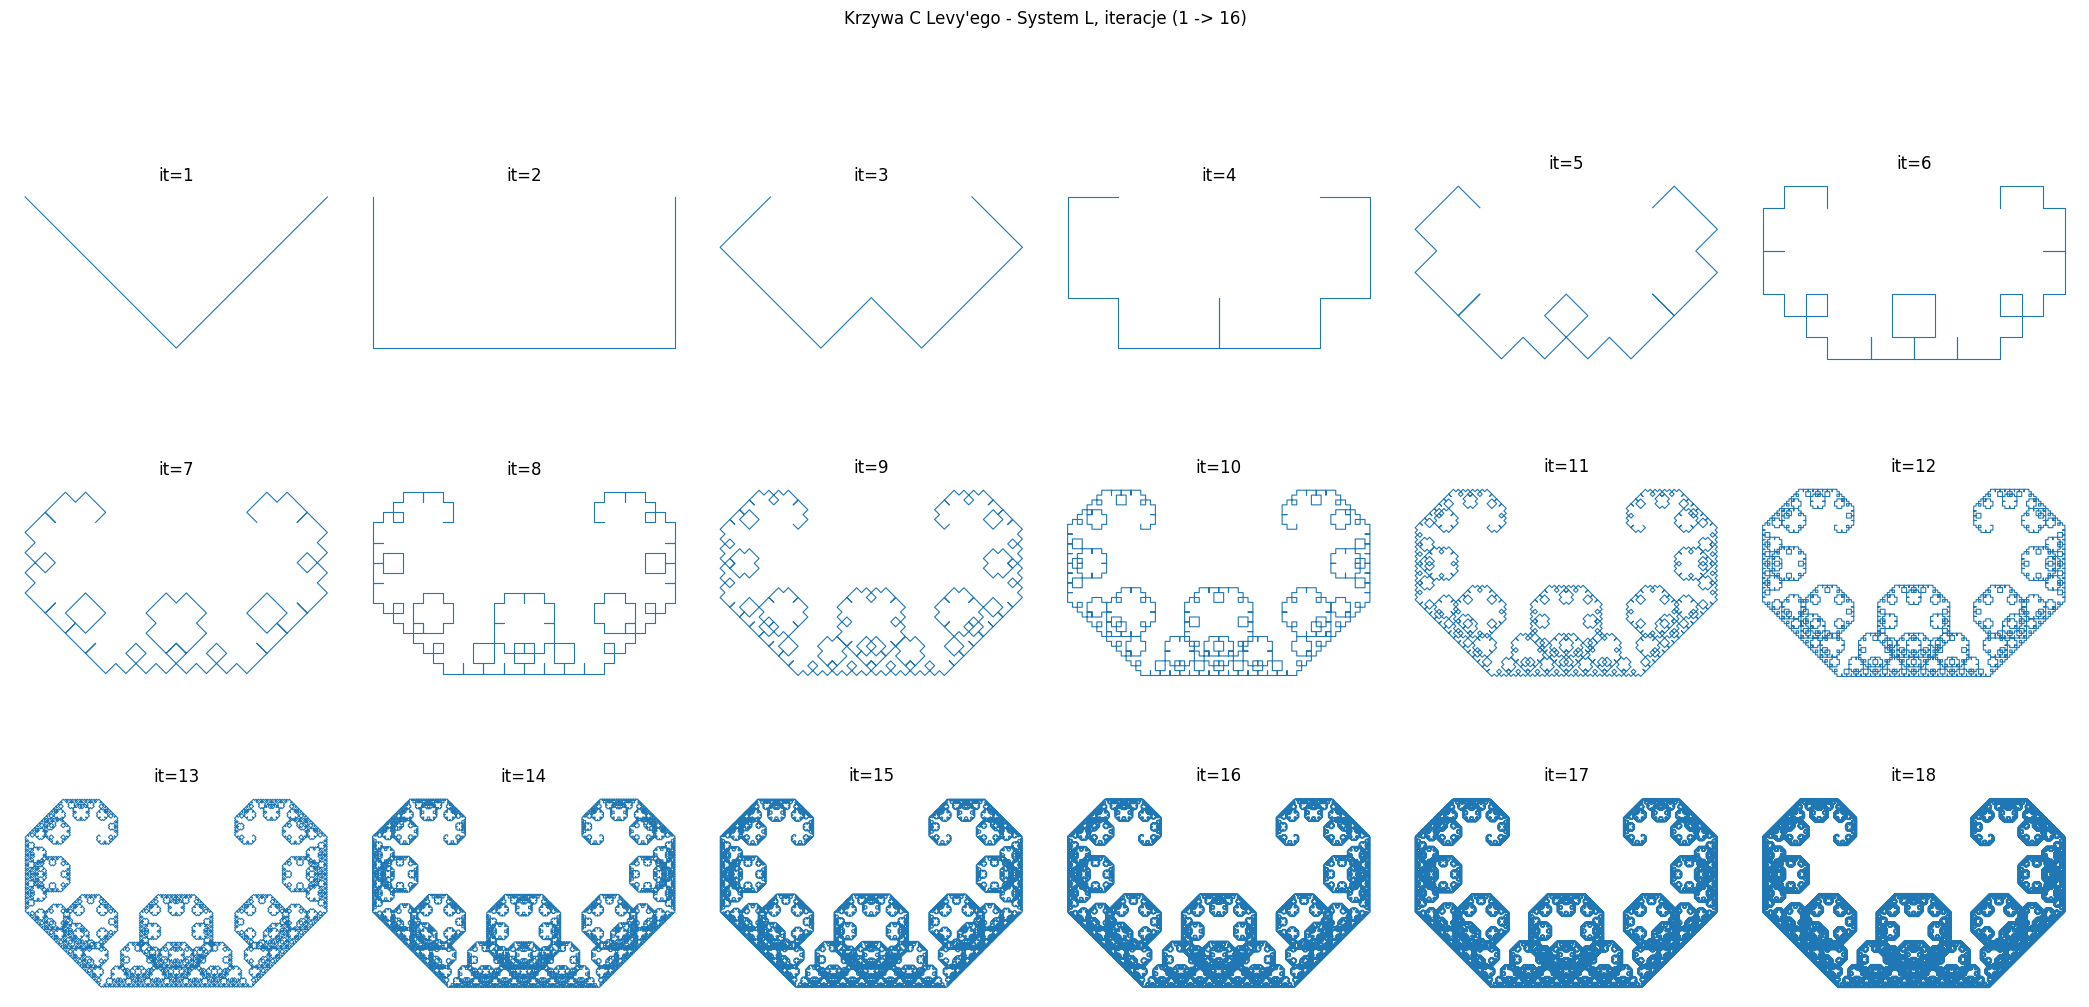

In [ ]:
# Wizualizacja progresji generacji krzywej Levy'ego dla systemu L, w zależności od iteracji
fig = plot_iterations_grid(iter_start=1, iter_stop=18, angle_deg=45.0)
fig.suptitle("Krzywa C Levy'ego - system L, iteracje (1 -> 16)", y=1.03)
plt.show()

### Classic (IFS / chaos game): dense point sampling

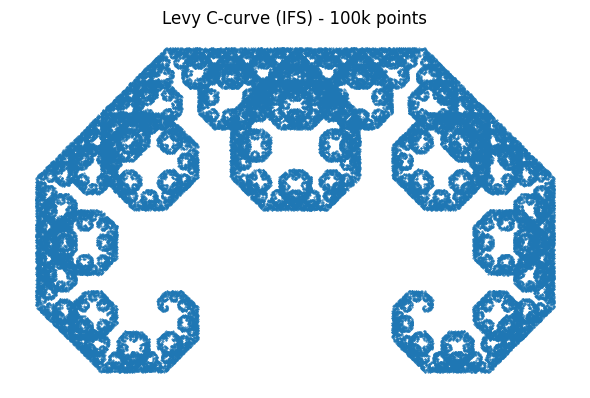

In [6]:
lc_ifs = LevyCCurve(method="ifs", n_points=100_000) 
pts_ifs = lc_ifs.generate()
fig = plot_scatter(pts_ifs, s=0.2, title="Levy C-curve (IFS) - 100k points")
plt.show()

#### Extra (Phase 1): Step size heuristic and polyline length

Our L-system interpreter uses `step = 2^{-iterations/2}` to keep the drawing within a bounded window.
The number of line segments doubles each iteration, so the polyline length grows approximately like
\(L_n \propto 2^{n/2}\). We can **measure** this growth to see the trend.

In [ ]:
def polyline_length(points):
    pts = np.asarray(points, dtype=float)
    diffs = np.diff(pts, axis=0)
    return float(np.sqrt((diffs**2).sum(axis=1)).sum())

iters = list(range(5, 13))
lengths = []
for it in iters:
    lc = LevyCCurve(method="lsystem", iterations=it, angle_deg=45.0)
    pts = lc.generate()
    lengths.append(polyline_length(pts))

plt.figure(figsize=(6,4))
plt.plot(iters, lengths, "o-")
plt.xlabel("iterations")
plt.ylabel("polyline length (relative units)")
plt.title("Length growth vs iterations (L-system with step=2^{-n/2})")
plt.grid(True, alpha=0.3)
plt.show()

## 2) Modification(s) of the classic curve

We'll demonstrate two kinds of modifications while retaining **self-similarity** and **iterative construction**:

1. **Generalized angle** in the IFS (\(\alpha \neq 45^\circ\)).  
2. **Stochastic L-system**: slight rule perturbation sampled randomly during expansion.

> Both preserve the fractal flavor; the first is a geometric deformation, the second injects controlled randomness.


### 2.1 Generalized-angle IFS (α-Lévy) — visual sweep

In [ ]:
angles = [20, 35, 45, 60]  # degrees
fig, axes = plt.subplots(1, len(angles), figsize=(3.6*len(angles), 3.6))
for ax, ang in zip(axes, angles):
    ifs = levy_ifs_generalized(angle_deg=ang)
    pts = ifs.sample(n_points=60_000, discard=100, seed=ang)
    xs, ys = zip(*pts)
    ax.scatter(xs, ys, s=0.15)
    ax.set_title(f"α = {ang}°")
    ax.set_aspect("equal")
    ax.axis("off")
fig.suptitle("Generalized-angle Lévy-like curves (IFS)")
fig.tight_layout()
plt.show()

### 2.2 Stochastic L-system variant

We'll define a **probabilistic rule** that occasionally perturbs the classic `+F--F+` pattern.
This is implemented here ad-hoc for clarity (we keep the standard turtle interpreter).

In [ ]:
import random
import math

def lsystem_expand_stochastic(axiom, iterations, p=0.25):
    """Expand with a probabilistic replacement for 'F'.
    With prob p use a perturbed rule; otherwise use the classic rule.
    """
    rule_classic = "+F--F+"
    rule_variant = "+F-+F-"
    s = axiom
    for _ in range(iterations):
        out = []
        for ch in s:
            if ch == "F":
                out.append(rule_variant if random.random() < p else rule_classic)
            else:
                out.append(ch)
        s = "".join(out)
    return s

def lsystem_interpret_turtle(instructions, angle_deg, step):
    x, y, heading = 0.0, 0.0, 0.0
    ang = math.radians(angle_deg)
    pts = [(x, y)]
    for ch in instructions:
        if ch == "F":
            x += step*math.cos(heading)
            y += step*math.sin(heading)
            pts.append((x, y))
        elif ch == "+":
            heading -= ang
        elif ch == "-":
            heading += ang
    return pts

# Demonstrate for a few probabilities
probs = [0.0, 0.15, 0.35, 0.6]
iters = 12
fig, axes = plt.subplots(1, len(probs), figsize=(3.6*len(probs), 3.6))
for ax, p in zip(axes, probs):
    instr = lsystem_expand_stochastic("F", iterations=iters, p=p)
    step = 2 ** (-iters/2)  # use same heuristic step
    pts = lsystem_interpret_turtle(instr, angle_deg=45.0, step=step)
    xs, ys = zip(*pts)
    ax.plot(xs, ys, linewidth=0.7)
    ax.set_title(f"p = {p:.2f}")
    ax.set_aspect("equal")
    ax.axis("off")
fig.suptitle("Stochastic Lévy-like L-systems")
fig.tight_layout()
plt.show()

## 3) Theory: classic construction & effect of modifications

- **Classic:** two self-similar copies scaled by \(1/\sqrt{2}\) at ±45°. Similarity dimension \(D=2\).
- **Generalized angle (IFS):** the scale remains \(1/\sqrt{2}\), so the *similarity dimension formula*
  still gives \(D=2\). Geometrically, the curve bends differently; local overlap patterns may change.
- **Stochastic L-system:** the rule set deviates locally, introducing **random micro-structures**, often
  increasing visual roughness. Self-similarity is preserved in a statistical sense; box-counting dimension
  stays close to 2 for the scales we probe.


## 4) Analysis & conclusions

In [ ]:
# Side-by-side: classic vs two modifications
fig, axes = plt.subplots(1, 3, figsize=(11, 3.6))

# Classic (L-system)
classic = LevyCCurve(method="lsystem", iterations=12, angle_deg=45.0).generate()
xs, ys = zip(*classic); axes[0].plot(xs, ys, linewidth=0.8)
axes[0].set_title("Classic (L-system, α=45°)"); axes[0].set_aspect("equal"); axes[0].axis("off")

# Generalized angle (IFS, α=35°)
ifs = levy_ifs_generalized(angle_deg=35.0)
pts = ifs.sample(n_points=80_000, discard=100, seed=42)
xs, ys = zip(*pts); axes[1].scatter(xs, ys, s=0.15)
axes[1].set_title("Modified IFS (α=35°)"); axes[1].set_aspect("equal"); axes[1].axis("off")

# Stochastic L-system (p=0.35)
instr = lsystem_expand_stochastic("F", iterations=12, p=0.35)
pts = lsystem_interpret_turtle(instr, angle_deg=45.0, step=2**(-12/2))
xs, ys = zip(*pts); axes[2].plot(xs, ys, linewidth=0.7)
axes[2].set_title("Stochastic L-system (p=0.35)"); axes[2].set_aspect("equal"); axes[2].axis("off")

fig.suptitle("Classic vs Modified Lévy-like Curves")
fig.tight_layout()
plt.show()

### Box-counting dimension (empirical)

We now estimate \(D\) with a straightforward box-counting procedure for each variant.
For self-similar Lévy-like constructions, we expect values **near 2** over a reasonable scale range.


In [ ]:
# Prepare point sets for box-counting (use polylines for apples-to-apples)
def make_points_classic(it=13, angle=45.0):
    return LevyCCurve(method="lsystem", iterations=it, angle_deg=angle).generate()

def make_points_angle_variant(it=13, angle=35.0):
    # Render via IFS, then sort points to reduce scatter noise effect (optional)
    ifs = levy_ifs_generalized(angle_deg=angle)
    return ifs.sample(n_points=120_000, discard=200, seed=123)

def make_points_stochastic(it=12, p=0.35, angle=45.0):
    instr = lsystem_expand_stochastic("F", iterations=it, p=p)
    step = 2 ** (-it/2)
    return lsystem_interpret_turtle(instr, angle_deg=angle, step=step)

deltas = [2**(-k) for k in range(3, 9)]

fig1, res1 = estimate_box_dimension(make_points_classic(13, 45.0), deltas, title_prefix="Classic")
fig2, res2 = estimate_box_dimension(make_points_angle_variant(13, 35.0), deltas, title_prefix="IFS α=35°")
fig3, res3 = estimate_box_dimension(make_points_stochastic(12, 0.35, 45.0), deltas, title_prefix="Stochastic p=0.35")
plt.show()

res1, res2, res3

### Conclusions

- **Preserved fractal features:** self-similarity (exact for classic; statistical for stochastic), iterative growth,
  and high visual complexity emerging from simple rules.
- **Visible differences:** generalized angle changes the global bending and overlap; stochastic rules add local
  irregularities and texture. Classic is more symmetric and regular.
- **Dimension:** both theory and our empirical box-counting fits indicate a dimension close to **2**.
- **Implementation notes:** L-system step scaling `2^{-n/2}` keeps figures reasonably bounded; IFS sampling
  benefits from discarding a short transient and using large `n_points` for smooth density.


## Extras

- **High-resolution exports:** use the CLI included in the repo, e.g.  
  `uv run levy-fractal draw lsystem --iter 14 --outfile levy_lsystem.png`
- **Batch comparisons:** `uv run levy-fractal compare --start 8 --stop 12 --outfile compare.png`
- **Dimension estimate:** `uv run levy-fractal dimension --iter 13 --outfile dim.png`
